## Introduction
This notebook looks at alternative methods for clustering and determining underlying distributions. 

Deterministic algorithms like K means clustering clearly define a data point as belonging to one cluster only.

However probablistic reality may involve a data point belonging to two or more distributions.

eg at a value of n, it could come from Group 1 with Probability XX%, or Group 2 with Probability YY%

One way of looking at it using Mixture Models

https://en.wikipedia.org/wiki/Mixture_model

This method works better when there is clear overlap between populations. k means works better if there is minimal overlap. 


## Existing material
In machine learning, the closest library I could find is the scikit-learn Gaussian Mixture Models

https://scikit-learn.org/stable/modules/mixture.html

However as noted, it uses Expectation Maximisation methods, with its associated advantages and disadvantages.

The biggest disadvantage is that is it only used for Gaussian distributions. So if you are analysing other distributions, you are out of luck.


## Proposed Alternative
One alternative is to utilise the methods and logic underpinning Chi Squared test.

It will work for any distribution which is already coded into scipy (or your other favourite library).

https://en.wikipedia.org/wiki/Chi-squared_test

Our machine should try to minimise the difference between the observed data and the proposed underlying distributions. 

Overview of methodology

-Divide the observed data provided into different bins.

-Quasi-randomly initiate distributions of which we think the underlying data is comprised of. For example, 2 normal distributions following mean1, variance1, proportion1, and mean2, variance2, proportion2. 

-Calculate the difference between the observed data in the bins, and the theoritical number of data points if our underlying distributions are correct. 

-Perturb the variables making up the distributions, and see which ways lowers the difference. 

-Adjust accordingly, and repeat until we cannot find anyway of lowering the difference between theoritical and observed

This notebook will focus on how well this method holds up vs GMM and the actual distribution.

In [1]:
# import the libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

#from scipy.stats import weibull_min
from scipy import stats

These are a bunch of functions used in the code

First, lets generate some random data to simulate an overlap in population. 

We will look at a two pop following a normal distribution. 

In [2]:
# this function generates two sets of normal data. you could change it to generate n sets of data
# it looks fairly pointless, but if you want to measure accuracy downstream, you need data1 data2 separate
def generate_normal_data(mean1, variance1, mean2, variance2, size1, size2):

    std_dev1 = np.sqrt(variance1)
    std_dev2 = np.sqrt(variance2)

    data1 = np.random.normal(loc=mean1, scale=std_dev1, size=size1)
    data2 = np.random.normal(loc=mean2, scale=std_dev2, size=size2)

    return data1, data2

In [3]:
# Set the random seed
np.random.seed(42)

In [4]:
# generate the data
mean1 = 0
variance1 = 1
mean2 = 1
variance2 = 3
size1 = 500
size2 = 500

data1, data2 = generate_normal_data(mean1, variance1, mean2, variance2, size1, size2)

merged_data = np.concatenate((data1, data2))

In [5]:
# get some basic stats
# Compute mean
mean = np.mean(merged_data)

# Compute variance
variance = np.var(merged_data, ddof=1)  # ddof=0 for population variance; use ddof=1 for sample variance

# Compute skewness
skewness = stats.skew(merged_data)

# Compute kurtosis
kurtosis = stats.kurtosis(merged_data)

# Print results
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

Mean: 0.5309812231686398
Variance: 2.1892297987739853
Skewness: 0.5288891226469098
Kurtosis: 0.477923653375266


From the skew and kurtosis, we can already tell that it is not a pure normal distribution

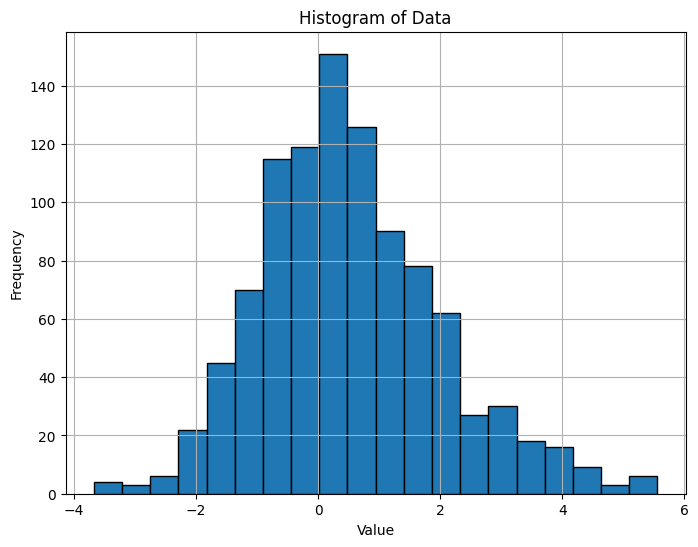

In [6]:
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(merged_data, bins=20, edgecolor='black')  
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show(block=True) # can remove if you want


A look at what the kmeans clustering algo sees.

In [7]:
# Create a KMeans instance with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
data_reshaped = merged_data.reshape(-1, 1)
# Fit the model to the data
kmeans.fit(data_reshaped)

# Get the centroids
centroids = kmeans.cluster_centers_

# Print the centroids
print("Centroids:")
print(centroids)

Centroids:
[[ 2.0139602 ]
 [-0.38957137]]


# Benchmark Returns in GMM
Lets get the benchmark regression from Guassian Mixture Models in Scikit learn

In [8]:
def get_GMM(merged_data):
    data3 = merged_data.reshape(-1, 1)
    # Initialize GaussianMixture with 2 components
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)

    # Fit the model
    gmm.fit(data3)

    # Extract means, variances, and proportions
    means = gmm.means_.flatten()  # Means of the Gaussian components
    covariances = gmm.covariances_  # Covariances of the Gaussian components
    weights = gmm.weights_  # Proportions (weights) of the Gaussian components

    return means, covariances, weights

In [9]:
# This section gets GMM answers
GMM_means, GMM_covariances, GMM_weights = get_GMM(merged_data)
print("pop1", "mean",GMM_means[0], "var",GMM_covariances[0],"prop",GMM_weights[0])
print("pop2", "mean",GMM_means[1], "var",GMM_covariances[1],"prop",GMM_weights[1])


pop1 mean 1.710478276078463 var [[2.12240684]] prop 0.35071867690561936
pop2 mean -0.10614113211352304 var [[1.06454612]] prop 0.6492813230943806


# Algorithm based on Chi Squared Test Methods

First up, these functions calculate the theoritical values which should occur between the bins, and the observed values from the data.

The CDF function can be edited if you want a different distribution. 

In [21]:
def cdf_between_consecutive_numbers(numbers, mean=0, variance=1):
    """
    Calculates the CDF between consecutive numbers in the list using a normal distribution.

    Parameters:
    - numbers: List of numbers to calculate CDF between consecutive elements.
    - mean: Mean of the normal distribution (default is 0).
    - variance: Variance of the normal distribution (default is 1).

    Returns:
    - List of CDF values between consecutive numbers.
    """
    # Convert variance to standard deviation
    std_dev = np.sqrt(variance)

    # List to hold the CDF values between consecutive numbers
    cdf_values = []

    # Iterate over consecutive pairs of numbers
    for i in range(len(numbers) + 1):
        #print(i)
        # Get the lower and upper bounds
        if i == 0:
            lower_bound = -999999
            upper_bound = numbers[i]
        elif i == len(numbers):
            lower_bound = numbers[i - 1]
            upper_bound = 999999
        else:
            lower_bound = numbers[i-1]
            upper_bound = numbers[i]

        # EDIT THE CDF YOU WANT HERE!
        
        # Calculate the CDF values for these bounds
        cdf_lower = norm.cdf(lower_bound, loc=mean, scale=std_dev)
        cdf_upper = norm.cdf(upper_bound, loc=mean, scale=std_dev)

        # The difference between the CDF values of upper and lower bounds
        cdf_between = cdf_upper - cdf_lower

        # Append the result to the list
        cdf_values.append(cdf_between)

    cdf_values = np.array(cdf_values)
    return cdf_values


def count_entries_within_boundaries(data, boundaries):
    """
    Counts the number of entries in the data array that fall within each boundary interval.

    Parameters:
    - data: Numpy array of data to be analyzed.
    - boundaries: List of boundary values defining the intervals.

    Returns:
    - List of counts for each interval defined by consecutive boundaries.
    """
    # Sort boundaries to ensure correct interval calculation
    sorted_boundaries = sorted(boundaries)

    # Initialize a list to hold counts
    counts = []

    # Iterate over consecutive pairs of boundaries
    for i in range(len(sorted_boundaries)+1):

        #print(i)
        # Get the lower and upper bounds
        if i == 0:
            lower_bound = -999999
            upper_bound = sorted_boundaries[i]
        elif i == len(sorted_boundaries):
            lower_bound = sorted_boundaries[i - 1]
            upper_bound = 999999
        else:
            lower_bound = sorted_boundaries[i - 1]
            upper_bound = sorted_boundaries[i]
        #print(lower_bound, upper_bound)

        #lower_bound = sorted_boundaries[i]
        #upper_bound = sorted_boundaries[i + 1]

        # Count the number of entries within the current interval
        count = np.sum((data >= lower_bound) & (data < upper_bound))
        counts.append(count)

    counts = np.array(counts)

    return counts

def get_chi_squared(pop_observed,numbers, mean_pop1,variance_pop1,proportion_pop1,mean_pop2, variance_pop2,proportion_pop2):

    pop1 = cdf_between_consecutive_numbers(numbers, mean_pop1, variance_pop1)
    pop2 = cdf_between_consecutive_numbers(numbers, mean_pop2, variance_pop2)

    pop_size = sum(pop_observed)  
    pop_merged = (pop1 * proportion_pop1 + pop2 * proportion_pop2) * pop_size

    # EDIT HERE FOR YOUR LOSS FUNCTION
    
    #loss_value = get_absolute_differences(pop_merged,pop_observed)
    #loss_value = get_squared_differences(pop_merged, pop_observed)
    loss_value = get_percent_differences(pop_merged, pop_observed)

    return loss_value

# Three board groups of functions:
- What are the bins for observation vs expected?
- What is the loss function to evaluate them?
- How should our Machine Learn?

# Bin Divisions

These functions determine the bin markers.

There are two main choices.
- Divide by equal length. in create_bins, we just linearly divide up the observed data.
- Divide by equal content. in create_bins_equal, we divide up the data so that every bin has an equal number of observations.

You can customise this as well. 

In [10]:
# bin plotting
# two choices
def create_bins(data, bin_size):
    """
    Creates a list of equally spaced intervals (bins) based on the given bin size.

    Parameters:
    - data: Numpy array of data to analyze.
    - bin_size: Number of bins to create.

    Returns:
    - List of bin edges.
    """
    # Determine the range of the data
    min_value = np.min(data)
    max_value = np.max(data)

    # Create bin edges using linspace
    bin_edges = np.linspace(min_value, max_value, num=bin_size + 1)

    return bin_edges

def create_bins_equal(data, bins):
    # Sort the array in ascending order
    sorted_data = np.sort(data)
    #n_element = np.size(data) / bins
    #n_elements = len(sorted_data)
    n_element = int(np.ceil(len(sorted_data) / bins))  # Ensure integer division with rounding up


    # Get every 10th element
    indices = np.arange(0, len(sorted_data), n_element)
    every_nth_elements = sorted_data[indices]

    # Check if the last element of the sorted array is included
    if every_nth_elements[-1] != sorted_data[-1]:
        every_nth_elements = np.append(every_nth_elements, sorted_data[-1])

    return every_nth_elements

# Loss Functions

These are the possible loss functions for each bin.
- get_absolute_differences: use the absolute differenece, then sum over all bins. This penalises all errors equally.
- get_squared_differences: use the squared difference, then sum. This penalises large errors in bins.
- get_percent_differences: use the squared difference, but divide by expected observations. This penalises large percentage errors in bins

You can pick and choose whichever one suits your needs and perferences. 
  

In [11]:
# loss functions
def get_absolute_differences(array1, array2):
    """
    Calculates the absolute differences between corresponding entries in two lists.

    Parameters:
    - list1: First list of numbers.
    - list2: Second list of numbers.

    Returns:
    - List of absolute differences between corresponding entries of list1 and list2.
    """
    if array1.shape != array2.shape:
        raise ValueError("Both arrays must be of equal shape.")

    # Calculate absolute differences
    differences = np.abs(array1 - array2)

    # Calculate the sum of the differences
    total_sum = float(np.sum(differences))

    return total_sum

def get_squared_differences(array1, array2):

    if array1.shape != array2.shape:
        raise ValueError("Both arrays must be of equal shape.")

    squared_diff = np.sum((array1 - array2) ** 2)
    squared_diff = float(squared_diff)
    return squared_diff

def get_percent_differences(array1, array2):

    if array1.shape != array2.shape:
        raise ValueError("Both arrays must be of equal shape.")

    squared_diff = np.sum((array1 - array2) ** 2 / array1)
    squared_diff = float(squared_diff)
    return squared_diff

# Machine Learning Options

Finally, we have two choices for deciding how to iterate and change the distribution values
- do_run_slow. This function looks for the which single value is changed the most by varying, and only adjusts it by the increment.
- do_run_fast. This function looks to adjust all values at the same time, in the direction to which will individually lower the difference.

note that the increment needs to be adjusted depending on the data and the bins chosen:
- If you data is on a different order of magnitude (eg variance is 30 and mean is 10, then adjusting by 0.01 may not have any effect)
- If your bin size is too big, then changing the increment may not result in any change in observed vs empirical.
- variance in general i make it at 5x the increment because otherwises there is no change in observed vs empirical. 


In [29]:
# two functions
def do_run_slow(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2,inc = 0.01):

    for x1 in range(1000):

        loss_value = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2,
                                     prop_pop2)

        loss_value_mp1p = get_chi_squared(pop_observed, numbers, mean_pop1 + inc, var_pop1, prop_pop1, mean_pop2,
                                          var_pop2, prop_pop2)
        loss_value_vp1p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1 + inc * 5, prop_pop1, mean_pop2,
                                          var_pop2, prop_pop2)
        loss_value_pp1p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1 + inc, mean_pop2,
                                          var_pop2, prop_pop2 - inc)
        loss_value_mp2p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2 + inc,
                                          var_pop2, prop_pop2)
        loss_value_vp2p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2,
                                          var_pop2 + 5 * inc, prop_pop2)
        loss_value_pp2p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1 - inc, mean_pop2,
                                          var_pop2, prop_pop2 + inc)

        loss_value_mp1n = get_chi_squared(pop_observed, numbers, mean_pop1 - inc, var_pop1, prop_pop1, mean_pop2,
                                          var_pop2, prop_pop2)
        loss_value_vp1n = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1 - 5 * inc, prop_pop1, mean_pop2,
                                          var_pop2, prop_pop2)
        loss_value_mp2n = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2 - inc,
                                          var_pop2, prop_pop2)
        loss_value_vp2n = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2,
                                          var_pop2 - 5 * inc, prop_pop2)

        variables_new = {
            'mean_pop1_p': loss_value_mp1p,
            'mean_pop1_n': loss_value_mp1n,
            'mean_pop2_p': loss_value_mp2p,
            'mean_pop2_n': loss_value_mp2n,
            'var_pop1_p': loss_value_vp1p,
            'var_pop1_n': loss_value_vp1n,
            'var_pop2_p': loss_value_vp2p,
            'var_pop2_n': loss_value_vp2n,
            'prop_pop1': loss_value_pp1p,
            'prop_pop2': loss_value_pp2p
        }

        smallest_name, smallest_value = min(variables_new.items(), key=lambda item: item[1])

        if smallest_value < loss_value:

            if smallest_name == 'mean_pop1_p':
                mean_pop1 += inc
                mean_pop1 = round(mean_pop1,2)
            elif smallest_name == 'mean_pop1_n':
                mean_pop1 -= inc
                mean_pop1 = round(mean_pop1,2)
            elif smallest_name == 'mean_pop2_p':
                mean_pop2 += inc
                mean_pop2 = round(mean_pop2,2)
            elif smallest_name == 'mean_pop2_n':
                mean_pop2 -= inc
                mean_pop2 = round(mean_pop2,2)
            elif smallest_name == 'var_pop2_p':
                var_pop2 += inc
                var_pop2 = round(var_pop2,2)
            elif smallest_name == 'var_pop2_n':
                var_pop2 -= inc
                var_pop2 = round(var_pop2,2)
            elif smallest_name == 'var_pop1_p':
                var_pop1 += inc
                var_pop1 = round(var_pop1,2)
            elif smallest_name == 'var_pop1_n':
                var_pop1 -= inc
                var_pop1 = round(var_pop1, 2)
            elif smallest_name == 'prop_pop1':
                prop_pop1 += inc
                prop_pop2 -= inc
                prop_pop1 = round(prop_pop1, 2)
                prop_pop2 = round(prop_pop2, 2)
            elif smallest_name == 'prop_pop2':
                prop_pop2 += inc
                prop_pop1 -= inc
                prop_pop1 = round(prop_pop1, 2)
                prop_pop2 = round(prop_pop2, 2)
            else:
                print('something went wrong!')
        else:
            print('we are done', x1, loss_value)
            #print(mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
            print("mean",mean_pop1,"var", var_pop1, "prop", prop_pop1)
            print("mean",mean_pop2, "var",var_pop2, "prop", prop_pop2)
            break

    return mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2, loss_value

def do_run_fast(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2,inc = 0.01):

    last_loss_value = float('inf')

    for x1 in range(1000):

        loss_value = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)

        loss_value_mp1p = get_chi_squared(pop_observed, numbers, mean_pop1 + inc, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
        loss_value_vp1p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1 + inc*5, prop_pop1, mean_pop2, var_pop2, prop_pop2)
        loss_value_pp1p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1 + inc, mean_pop2, var_pop2, prop_pop2 - inc)
        loss_value_mp2p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2 + inc, var_pop2, prop_pop2)
        loss_value_vp2p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2 + 5*inc, prop_pop2)
        loss_value_pp2p = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1 - inc, mean_pop2, var_pop2, prop_pop2 + inc)

        loss_value_mp1n = get_chi_squared(pop_observed, numbers, mean_pop1 - inc, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
        loss_value_vp1n = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1 - 5*inc, prop_pop1, mean_pop2, var_pop2, prop_pop2)

        loss_value_mp2n = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2 - inc, var_pop2, prop_pop2)
        loss_value_vp2n = get_chi_squared(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2 - 5*inc, prop_pop2)

        changed = False
        if loss_value_mp1p < loss_value_mp1n and loss_value_mp1p < loss_value:
            mean_pop1 += inc
            mean_pop1 = round(mean_pop1, 2)
            changed = True
        elif loss_value_mp1p > loss_value_mp1n and loss_value_mp1n < loss_value:
            mean_pop1 -= inc
            mean_pop1 = round(mean_pop1, 2)
            changed = True

        if loss_value_mp2p < loss_value_mp2n and loss_value_mp2p < loss_value:
            mean_pop2 += inc
            mean_pop2 = round(mean_pop2, 2)
            changed = True
        elif loss_value_mp2n < loss_value_mp2p and loss_value_mp2n < loss_value:
            mean_pop2 -= inc
            mean_pop2 = round(mean_pop2, 2)
            changed = True

        if loss_value_vp1p < loss_value_vp1n and loss_value_vp1p < loss_value:
            var_pop1 += inc * 5
            var_pop1 = round(var_pop1, 2)
            changed = True
        elif loss_value_vp1n < loss_value_vp1p and loss_value_vp1n < loss_value:
            var_pop1 -= inc * 5
            var_pop1 = round(var_pop1, 2)
            changed = True

        if loss_value_vp2p < loss_value_vp2n and loss_value_vp2p < loss_value:
            var_pop2 += inc * 5
            var_pop2 = round(var_pop2, 2)
            changed = True
        elif loss_value_vp2n < loss_value_vp2p and loss_value_vp2n < loss_value:
            var_pop2 -= inc * 5
            var_pop2 = round(var_pop2, 2)
            changed = True

        if loss_value_pp2p < loss_value_pp1p and loss_value_pp2p < loss_value:
            prop_pop2 += inc
            prop_pop1 -= inc
            prop_pop1 = round(prop_pop1, 2)
            prop_pop2 = round(prop_pop2, 2)
            changed = True
        elif loss_value_pp1p < loss_value_pp2p and loss_value_pp1p < loss_value:
            prop_pop2 -= inc
            prop_pop1 += inc
            prop_pop1 = round(prop_pop1, 2)
            prop_pop2 = round(prop_pop2, 2)
            changed = True
        #print(mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)

        if loss_value < last_loss_value:
            last_loss_value = loss_value
        else:
            print('we are done', x1, loss_value)
            print("mean",mean_pop1,"var", var_pop1, "prop", prop_pop1)
            print("mean",mean_pop2, "var",var_pop2, "prop", prop_pop2)
            break

        if changed == False:
            print('we are done',x1, loss_value)
            print("mean",mean_pop1,"var", var_pop1, "prop", prop_pop1)
            print("mean",mean_pop2, "var",var_pop2, "prop", prop_pop2)
            break
        else:
            pass

    return mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2, loss_value


Some miscellanous code, just some functions or data structures to store information. 

In [23]:
# store the intial data. it can be reused. 
variables = {
    'mean_pop1': mean1,
    'var_pop1': variance1,
    'prop_pop1': size1,
    'mean_pop2': mean2,
    'var_pop2': variance2,
    'prop_pop2': size2
}


def store_variables(mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2):

    new_list = [mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2]

    return new_list


# Running the Algo

We have selected Percentage Difference for the loss function and equal amounts of our data per bin. 

In [18]:
# store our run values in this dictionary. 
# you can use a nested list as well but downstream will need editing
run_results = {}

In [25]:
# initial the guesses. you can start from what looks like decent values
mean_pop1 = -0.5
var_pop1 = 2
prop_pop1 = 0.5
mean_pop2 = 0.6
var_pop2 = 4
prop_pop2 = 0.5

variables_guess = {
    'mean_pop1': mean_pop1,
    'var_pop1': var_pop1,
    'prop_pop1': prop_pop1,
    'mean_pop2': mean_pop2,
    'var_pop2': var_pop2,
    'prop_pop2': prop_pop2
}

In [26]:
# choose your bin values and distribution
bins = 30

#numbers = create_bins(merged_data, bins)
numbers = create_bins_equal(merged_data, bins)

pop_observed = count_entries_within_boundaries(merged_data, numbers)

# do perturb
inc = 0.01

mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2,loss_value = do_run_fast(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
fast_run = store_variables(mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
run_results[loss_value]= fast_run

we are done 48 29.597292086550247
mean -0.07 var 0.8 prop 0.44
mean 1.01 var 2.8 prop 0.56


In [30]:
# re-initial the guesses
mean_pop1 = variables_guess['mean_pop1']
var_pop1 = variables_guess['var_pop1']
prop_pop1 = variables_guess['prop_pop1']
mean_pop2 = variables_guess['mean_pop2']
var_pop2 = variables_guess['var_pop2']
prop_pop2 = variables_guess['prop_pop2']

mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2,loss_value= do_run_slow(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
slow_run = store_variables(mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
run_results[loss_value]= slow_run

we are done 342 28.872573538845774
mean -0.03 var 0.94 prop 0.51
mean 1.13 var 2.85 prop 0.49


In [33]:
# this block just prints the results
print('original values')
for key, value in variables.items():
    print(key,value)
print('fast run')
#print(fast_run)
print("mean",fast_run[0],"var", fast_run[1], "prop", fast_run[2])
print("mean",fast_run[3], "var",fast_run[4], "prop", fast_run[5])
print('slow run')
#print(slow_run)
print("mean",slow_run[0],"var", slow_run[1], "prop", slow_run[2])
print("mean",slow_run[3], "var",slow_run[4], "prop", slow_run[5])
print("GMM Values")
print("pop1", GMM_means[0], GMM_covariances[0],GMM_weights[0])
print("pop2", GMM_means[1], GMM_covariances[1],GMM_weights[1])



original values
mean_pop1 0
var_pop1 1
prop_pop1 500
mean_pop2 1
var_pop2 3
prop_pop2 500
fast run
mean -0.07 var 0.8 prop 0.44
mean 1.01 var 2.8 prop 0.56
slow run
mean -0.03 var 0.94 prop 0.51
mean 1.13 var 2.85 prop 0.49
GMM Values
pop1 1.710478276078463 [[2.12240684]] 0.35071867690561936
pop2 -0.10614113211352304 [[1.06454612]] 0.6492813230943806


In [34]:
# if you run many times, this block prints the results stored
for key, value in run_results.items():
    print(key, value)


29.597292086550247 [-0.07, 0.8, 0.44, 1.01, 2.8, 0.56]
28.872573538845774 [-0.03, 0.94, 0.51, 1.13, 2.85, 0.49]


# Time to visualise the results

In [47]:
# used for plotting graphs only. Its similiar to an above function which returned difference things
def get_obs_act(merged_data,numbers, mean_pop1,variance_pop1,proportion_pop1,mean_pop2, variance_pop2,proportion_pop2,pop_size):

    pop_observed = count_entries_within_boundaries(merged_data, numbers)

    pop1 = cdf_between_consecutive_numbers(numbers, mean_pop1, variance_pop1)
    pop2 = cdf_between_consecutive_numbers(numbers, mean_pop2, variance_pop2)
    pop_merged = (pop1 * proportion_pop1 + pop2 * proportion_pop2) * pop_size

    #chi_squared,loss_value = absolute_differences(pop_merged,pop_observed)

    return pop_merged,pop_observed


def do_plot_compare(merged_data,numbers,mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2):
    pop_size = np.size(merged_data)

    pop_merged,pop_observed = get_obs_act(merged_data,numbers, mean_pop1,var_pop1,prop_pop1,mean_pop2, var_pop2,prop_pop2, pop_size)

    #pop_gmm,pop_observed = get_obs_act(merged_data,numbers, float(GMM_means[0]),float(GMM_covariances[0][0][0]),float(GMM_weights[0]),float(GMM_means[0]),float(GMM_covariances[1][0][0]),float(GMM_weights[1]), pop_size)
    pop_gmm,pop_observed = get_obs_act(merged_data,numbers, GMM_means[0],GMM_covariances[0][0][0],GMM_weights[0],GMM_means[1],GMM_covariances[1][0][0],GMM_weights[1], pop_size)
    x = np.arange(bins+2)
    bar_width = 0.35

    # Create a bar chart
    plt.figure(figsize=(12, 8))

    # Plot bars for the first array
    plt.bar(x - bar_width, pop_observed, bar_width, label='Observed', color='b')

    # Plot bars for the second array
    plt.bar(x , pop_merged, bar_width, label='Predicted', color='r')

    plt.bar(x + bar_width, pop_gmm, bar_width, label='GMM', color='g')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('Bar Chart of Two NumPy Arrays')
    plt.legend()

    # Display the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    #plt.xticks(x)  # Ensure x-axis ticks are centered
    plt.show(block=True)

In [ ]:
# This section is optional. Reset it to whatever values you want, else it just uses the last ones in the memory

mean_pop1 = -0.5
var_pop1 = 1
prop_pop1 = 0.5
mean_pop2 = 1.5
var_pop2 = 2
prop_pop2 = 0.5



In [46]:
print("pop1", GMM_means[0], GMM_covariances[0][0][0],GMM_weights[0])
print("pop2", GMM_means[1], GMM_covariances[1][0][0],GMM_weights[1])

pop1 1.710478276078463 2.1224068383570733 0.35071867690561936
pop2 -0.10614113211352304 1.0645461155093616 0.6492813230943806


We are going to plot some histograms.
The first one plots the equal spaced histogram, the second plots the equal data histogram


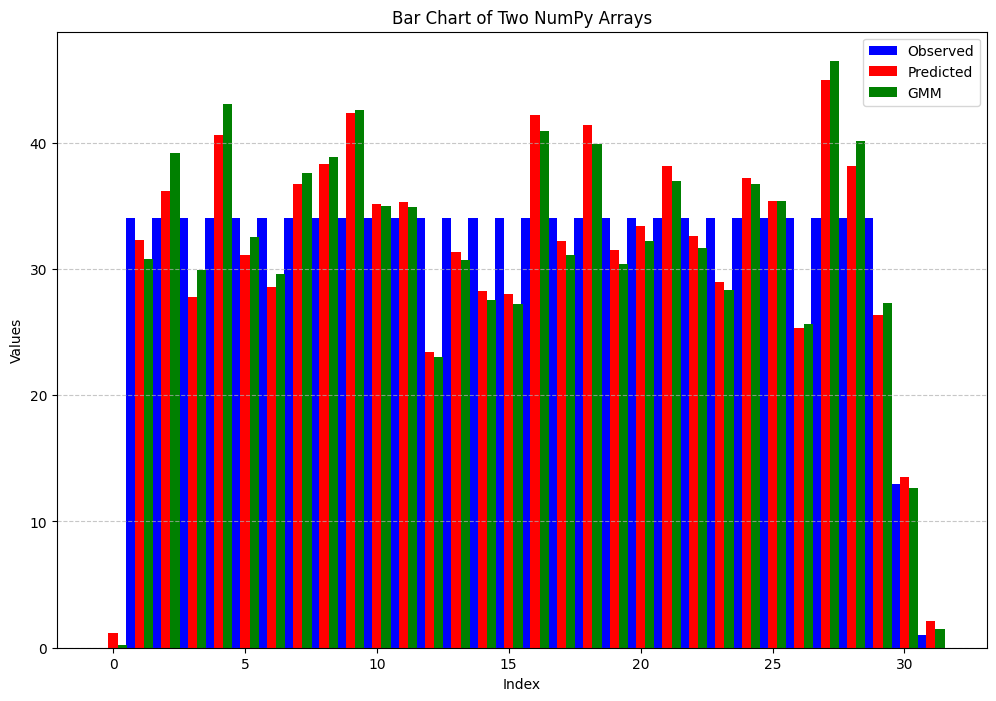

In [48]:
do_plot_compare(merged_data,numbers,mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2)

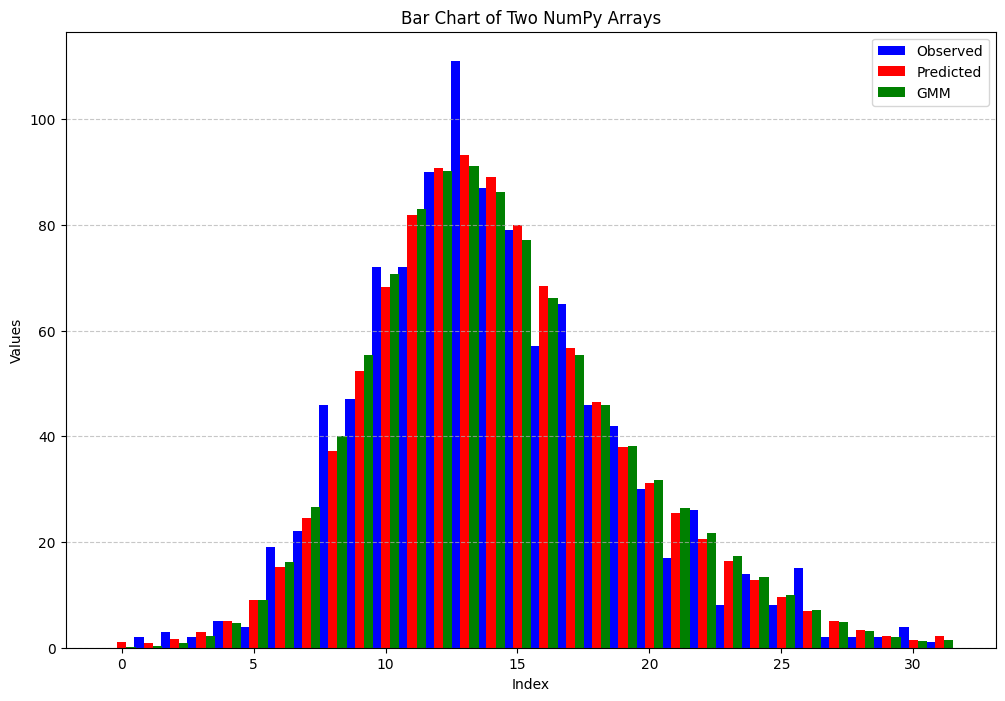

In [50]:
# equal spaced graph
bins = 30

numbers_2 = create_bins(merged_data, bins)

do_plot_compare(merged_data,numbers_2,mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2)

Lets see how it tackles a different set of values, one with a smaller subset

In [63]:
np.random.seed(42)

# Generate the simulated data
mean1 = 0
variance1 = 1
mean2 = 1
variance2 = 3
size1 = 100
size2 = 500

variables_new = {
    'mean_pop1': mean1,
    'var_pop1': variance1,
    'prop_pop1': size1,
    'mean_pop2': mean2,
    'var_pop2': variance2,
    'prop_pop2': size2
}
data1, data2 = generate_normal_data(mean1, variance1, mean2, variance2, size1, size2)

merged_data = np.concatenate((data1, data2))


Run the GMM. we need to specify values, else the random init will not go well. 

In [53]:
initial_means = np.array([[-0.5], [2]])
initial_covariances = np.array([[0.5], [1.0]])  
initial_weights = np.array([0.1, 0.9])

data3 = merged_data.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
# Set initial parameters
gmm.means_init = initial_means
gmm.covariances_init = initial_covariances
gmm.weights_init = initial_weights

In [66]:
# Fit the model

gmm.fit(data3)

# Retrieve the means, covariances, and weights
GMM_means = gmm.means_.flatten()
GMM_covariances = gmm.covariances_.flatten()
GMM_weights = gmm.weights_

print("Means:", GMM_means)
print("Covariances:", GMM_covariances)
print("Weights:", GMM_weights)


Means: [-0.31444066  1.36634493]
Covariances: [1.06160315 2.60703007]
Weights: [0.3235139 0.6764861]


In [55]:

# initial the guesses
mean_pop1 = -0.5
var_pop1 = 0.5
prop_pop1 = 0.1
mean_pop2 = 2
var_pop2 = 1
prop_pop2 = 0.9

variables_guess = {
    'mean_pop1': mean_pop1,
    'var_pop1': var_pop1,
    'prop_pop1': prop_pop1,
    'mean_pop2': mean_pop2,
    'var_pop2': var_pop2,
    'prop_pop2': prop_pop2
}

bins = 30

#numbers = create_bins(merged_data, bins)
numbers = create_bins_equal(merged_data, bins)

pop_observed = count_entries_within_boundaries(merged_data, numbers)

# do perturb
inc = 0.01


mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2,loss_value = do_run_fast(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
fast_run = store_variables(mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
run_results[loss_value]= fast_run
# initial the guesses
mean_pop1 = variables_guess['mean_pop1']
var_pop1 = variables_guess['var_pop1']
prop_pop1 = variables_guess['prop_pop1']
mean_pop2 = variables_guess['mean_pop2']
var_pop2 = variables_guess['var_pop2']
prop_pop2 = variables_guess['prop_pop2']

mean_pop1,var_pop1,prop_pop1,mean_pop2,var_pop2,prop_pop2,loss_value= do_run_slow(pop_observed, numbers, mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
slow_run = store_variables(mean_pop1, var_pop1, prop_pop1, mean_pop2, var_pop2, prop_pop2)
run_results[loss_value]= slow_run



we are done 169 31.566752110261586
mean 0.52 var 1.9 prop 0.78
mean 1.99 var 4.65 prop 0.22
we are done 711 31.676236978764635
mean 0.49 var 1.81 prop 0.76
mean 1.98 var 4.43 prop 0.24


In [67]:
print('original values')
for key, value in variables_new.items():
    print(key,value)
print('fast run')
#print(fast_run)
print("mean",fast_run[0],"var", fast_run[1], "prop", fast_run[2])
print("mean",fast_run[3], "var",fast_run[4], "prop", fast_run[5])
print('slow run')
#print(slow_run)
print("mean",slow_run[0],"var", slow_run[1], "prop", slow_run[2])
print("mean",slow_run[3], "var",slow_run[4], "prop", slow_run[5])
print("GMM Values")
print("pop1", GMM_means[0], GMM_covariances[0],GMM_weights[0])
print("pop2", GMM_means[1], GMM_covariances[1],GMM_weights[1])

original values
mean_pop1 0
var_pop1 1
prop_pop1 100
mean_pop2 1
var_pop2 3
prop_pop2 500
fast run
mean 0.52 var 1.9 prop 0.78
mean 1.99 var 4.65 prop 0.22
slow run
mean 0.49 var 1.81 prop 0.76
mean 1.98 var 4.43 prop 0.24
GMM Values
pop1 -0.3144406562882985 1.0616031485544846 0.3235139019592814
pop2 1.3663449257728812 2.6070300722139588 0.6764860980407186


Turns out our algorithm works quite well! 

It gets the proportions way closer, but mean and variance are different

We could probably get better results by playing around with it

# Visualisation
Another way of visualising is to look at how it compares to the GMM

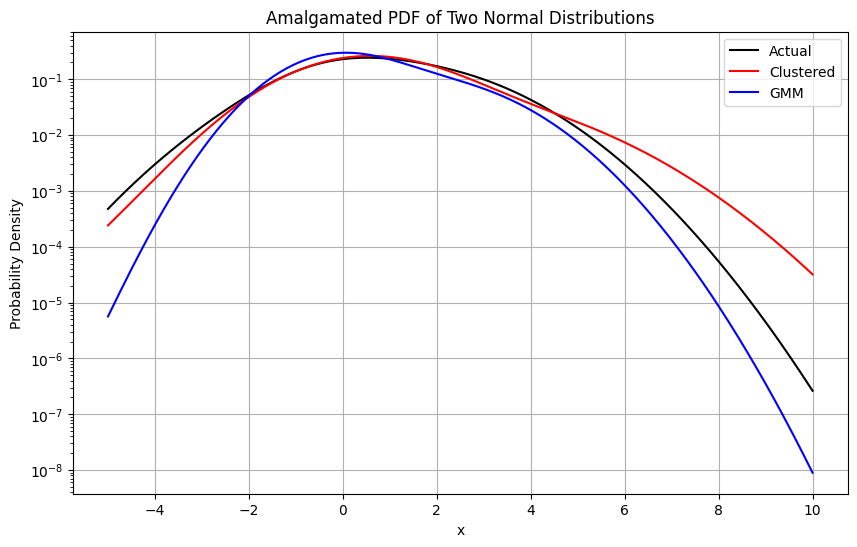

In [61]:

# Define the range of x values
x = np.linspace(-5, 10, 1000)

# Compute the PDF for each normal distribution
pdf1 = norm.pdf(x, mean1, variance1**0.5)
pdf2 = norm.pdf(x, mean2, variance2**0.5)
pdf3 = norm.pdf(x, mean_pop1, var_pop1 ** 0.5)
pdf4 = norm.pdf(x, mean_pop2, var_pop2 ** 0.5)
pdf5 = norm.pdf(x, GMM_means[0], float(GMM_covariances[0][0][0])**0.5)
pdf6 = norm.pdf(x, GMM_means[1], float(GMM_covariances[1][0][0])**0.5)
# Combine the PDFs (for example, we can simply add them, or use a weighted sum)
amalgamated_pdf = pdf1 * size1 /(size1+size2) + pdf2 * size2 /(size1+size2) # If you want a weighted sum, adjust accordingly
amalgamated_pdf2 = pdf3 * prop_pop1 + pdf4 * prop_pop2
amalgamated_pdf3 = pdf5 * GMM_weights[0] + pdf6 * GMM_weights[1]
# Plot the individual PDFs and the amalgamated PDF
plt.figure(figsize=(10, 6))
plt.plot(x, amalgamated_pdf, label='Actual', color='black')
plt.plot(x, amalgamated_pdf2, label='Clustered', color='red')
plt.plot(x, amalgamated_pdf3, label='GMM', color='blue')
plt.yscale('log')
plt.title('Amalgamated PDF of Two Normal Distributions')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show(block=True)

The clustering method is surprising close.

The results could be better or worse by changing loss function, bin selection, or other starting variables. 

# Conclusion:

The current method works well when compared to GMM. 

There is no full proof method to determining underlying distributions, but this method offers a flexible (but slower) way of working with non gaussian methods. 